In [2]:
import chromatix.functional as cf
import jax.numpy as jnp
from chromatix.utils.fft import fft, ifft
from jax import Array
from jax.lax import scan
from jax.typing import ArrayLike
from sample import paper_sample
from tensor_tomo import PTFT
import matplotlib.pyplot as plt


%config InlineBackend.figure_format='retina'

In [36]:
# Our input field is a plane wave
shape = (5 * 180, 5 * 180) # sample size
spacing = 0.065 # from paper
wavelength = 0.405 # from paper
nm = 1.33
polarisation = cf.linear(0) # x-polarised light

in_field = cf.plane_wave(shape, spacing, wavelength, 1.0, amplitude=polarisation, scalar=False, pupil=lambda f: cf.square_pupil(f, w = 180* spacing), power=100)

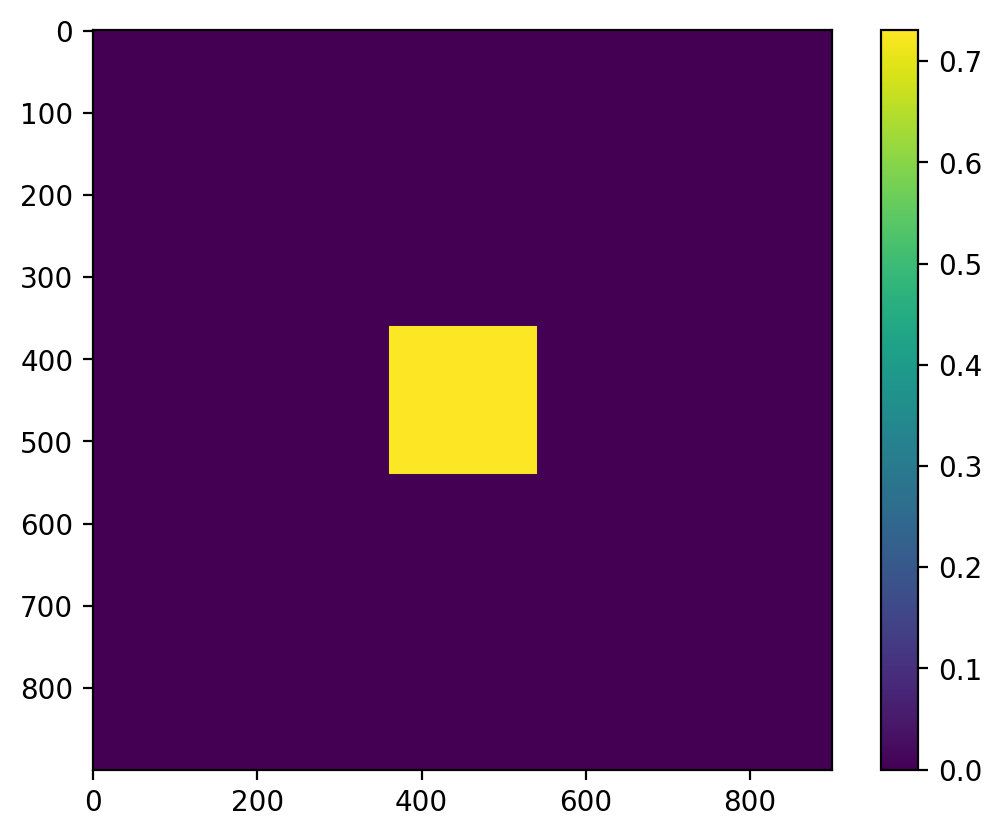

In [37]:
plt.imshow(in_field.intensity.squeeze())
plt.colorbar()

In [42]:
# Sample from the paper
sample = paper_sample()
print(f"Sample shape: {sample.shape}")

# Adding some padding for the propagation.
sample = cf.center_pad(sample, (0, 2 * 180, 2 * 180, 0, 0))

print(f"Padded sample shape: {sample.shape}")

Sample shape: (70, 180, 180, 3, 3)
Padded sample shape: (70, 900, 900, 3, 3)


In [43]:
def matvec(a: ArrayLike, b: ArrayLike) -> Array:
    return jnp.matmul(a, b[..., None]).squeeze(-1)

def thick_polarised_sample(field: cf.VectorField, potential: ArrayLike, nm: ArrayLike, dz: ArrayLike) -> cf.VectorField:
    def Q_op(u: Array) -> Array:
        # correct
        """Polarisation transfer operator"""
        return ifft(matvec(Q, fft(u)))
    
    def H_op(u: Array) -> Array:
        # correct
        """Vectorial scattering operator"""
        prefactor = -1j * dz / 2 * jnp.exp(1j * kz * dz) / kz
        prefactor = jnp.where(kz > 0, prefactor, 0)
        return ifft(matvec(Q, prefactor * fft(u)))
    
    def P_op(u: Array) -> Array:
        # correct
        """Vectorial free space operator"""
        # NOTE: Really need to check if we deal correctly with evanescent waves
        prefactor = jnp.where(kz > 0,  jnp.exp(1j * kz * dz), 0)

        # NOTE: Are we not overlapping stuff by not not padding?
        return ifft(matvec(Q, prefactor * fft(u)))

    def propagate_slice(u: Array, potential_slice: Array) -> tuple[Array, None]:
        scatter_field = matvec(potential_slice, Q_op(u))
        return P_op(u) + H_op(scatter_field), None

    # Preliminaries
    # We shift the k_grid so it aligns with unshifted fft output
    k_grid = jnp.fft.ifftshift(field.k_grid, axes=field.spatial_dims)

    # We use z yx ordering, and add the 2pi factor to chromatix kgrrid
    # We chop off evanescent waves
    # NOTE: understand why we need nm here
    km = 2 * jnp.pi * nm / field.spectrum
    k_grid = 2 * jnp.pi * k_grid
    kz = jnp.sqrt(jnp.maximum(0.0, km**2 - jnp.sum(k_grid**2, axis=0))) 
    k_grid =  jnp.concatenate([kz[None, ...], k_grid], axis=0)

    # Calculating PTFT
    Q = PTFT(k_grid, km).squeeze(-3)

    # Running scan over sample
    u, _ = scan(propagate_slice, field.u, potential[..., None, :, :])
    return field.replace(u=u)

In [47]:
# Running the simulation
field = thick_polarised_sample(in_field, sample, 1.33, 0.065)


# Making plotting a little easier
# ::-1 to invert y axis
amplitude = field.amplitude.squeeze()
amplitude = amplitude[::-1][360:-360, 360:-360]

phase = field.phase.squeeze()
phase = phase[::-1][360:-360, 360:-360]

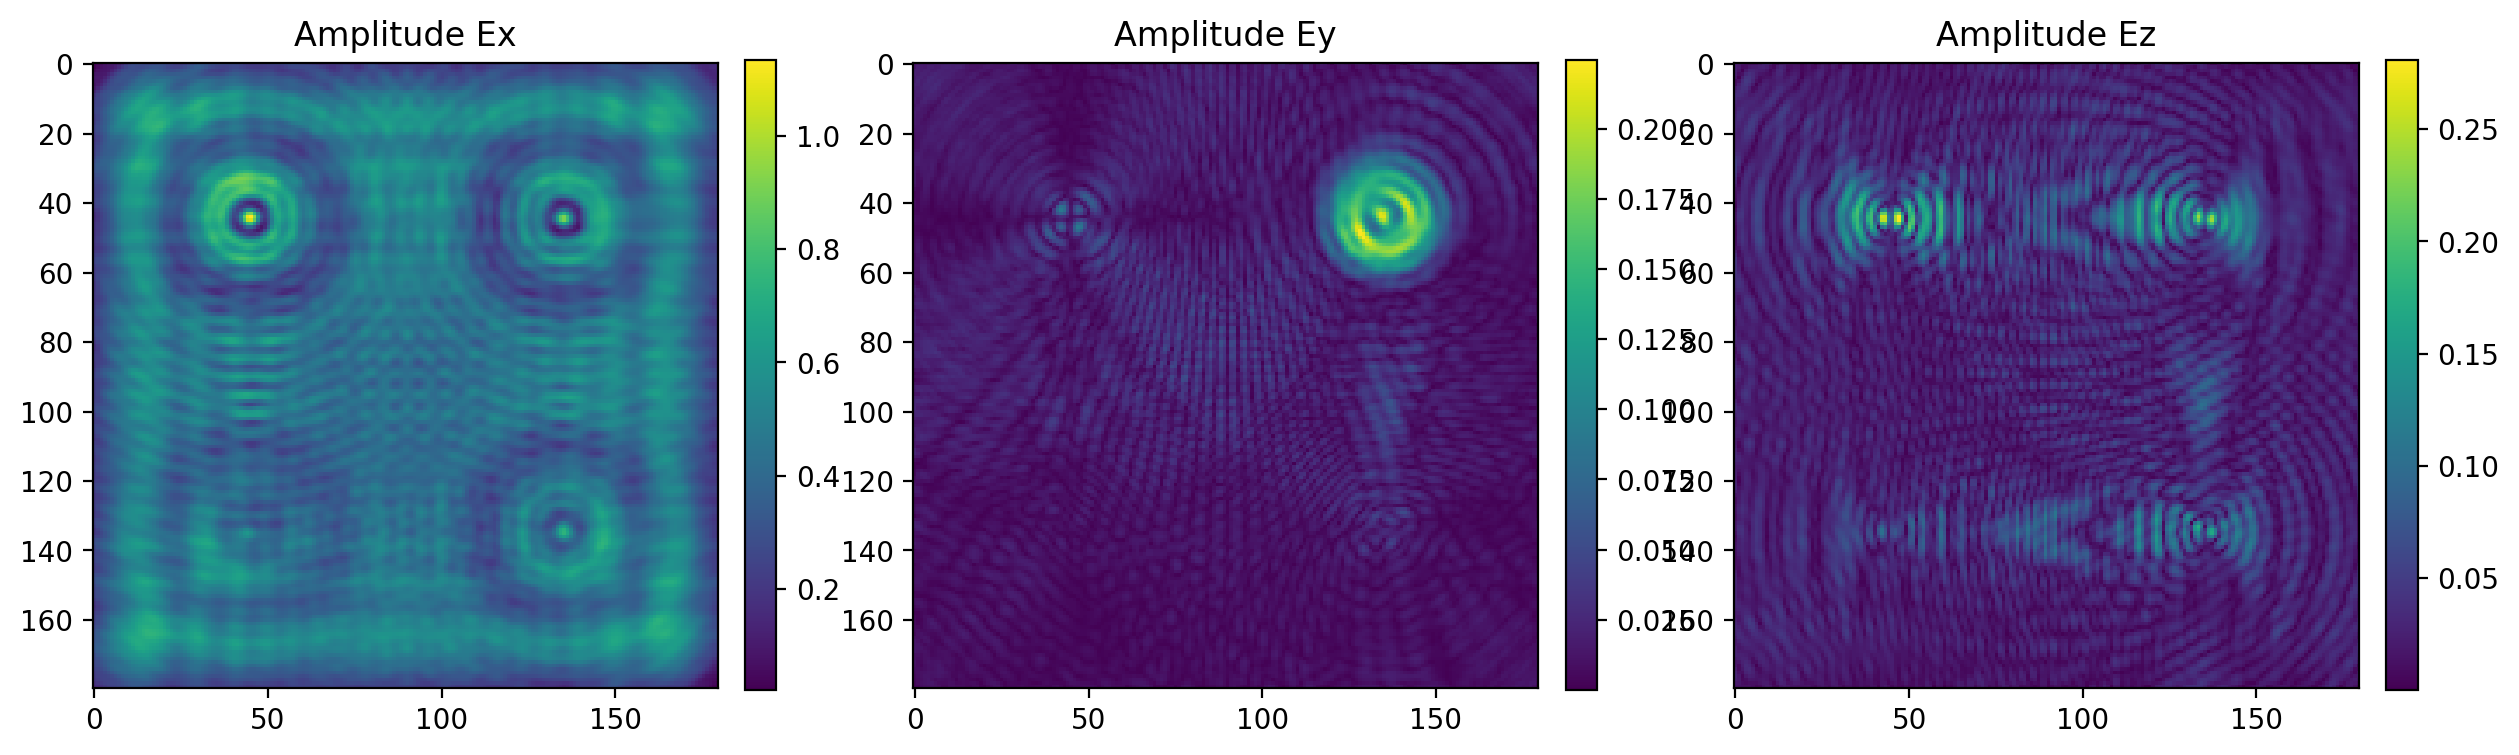

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Amplitude Ex")
plt.imshow(amplitude[..., 2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Amplitude Ey")
plt.imshow(amplitude[..., 1])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Amplitude Ez")
plt.imshow(amplitude[..., 0])
plt.colorbar(fraction=0.046, pad=0.04)

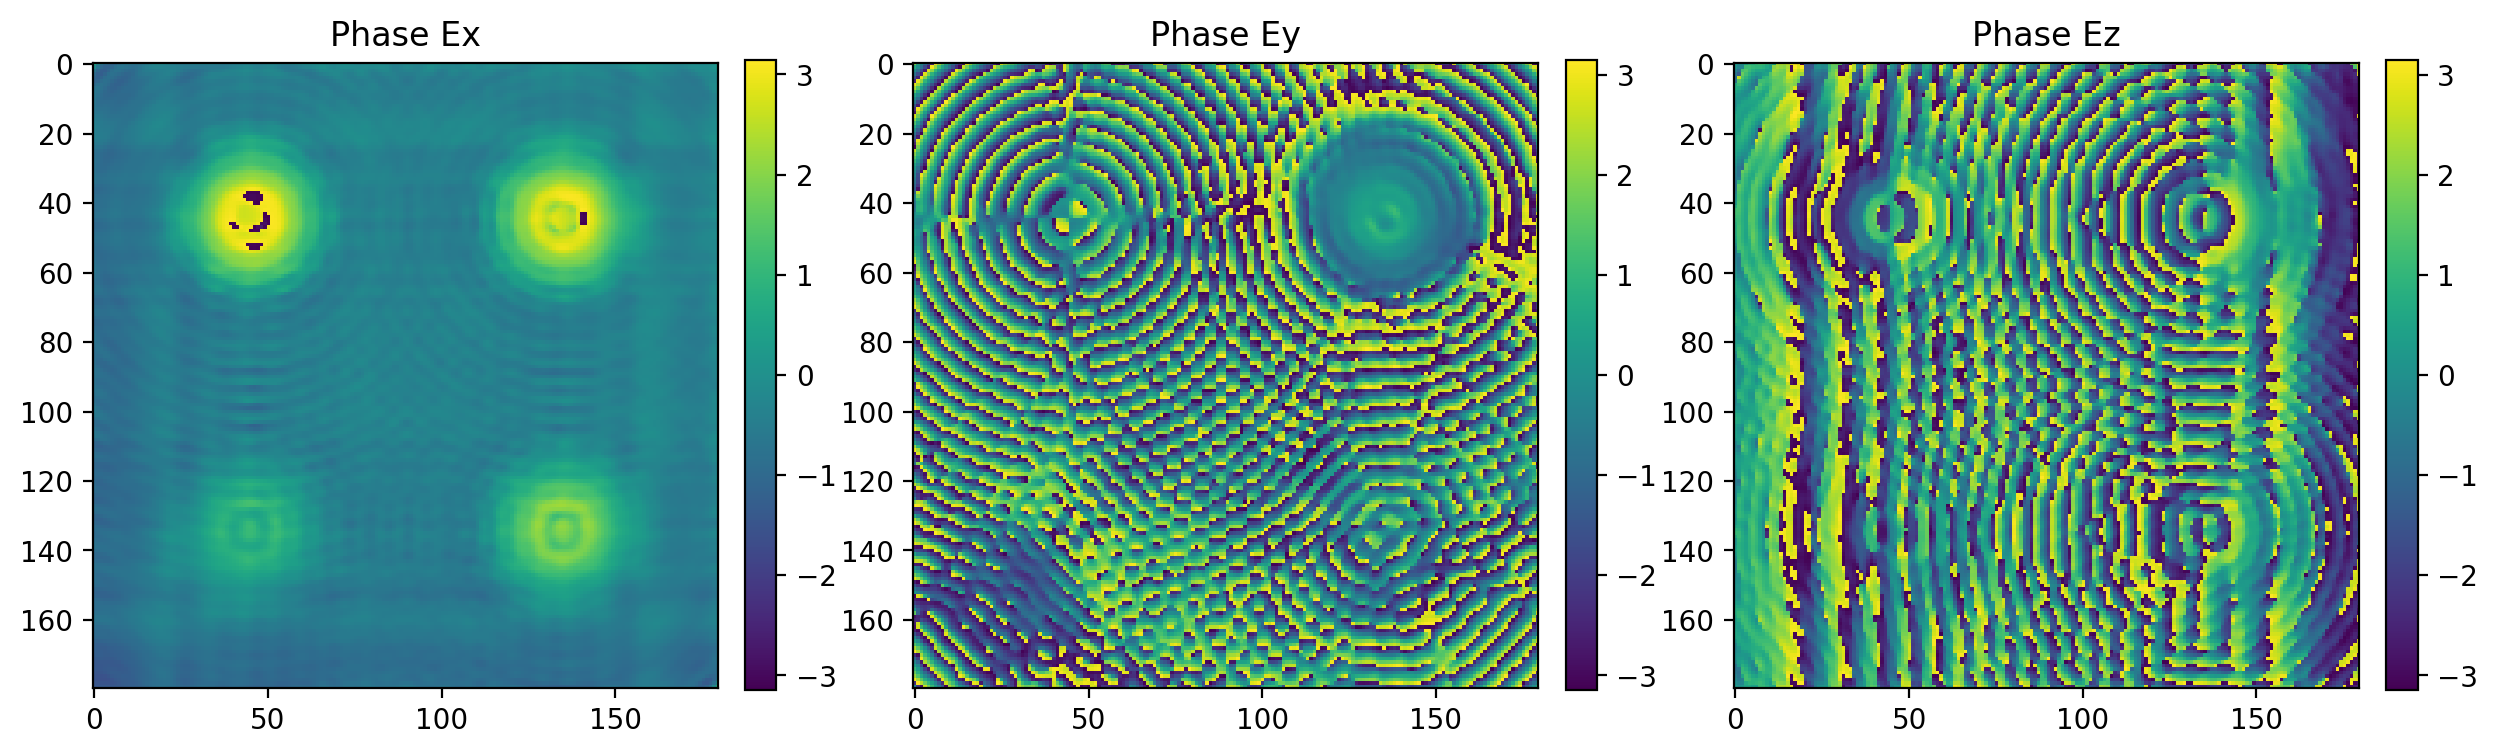

In [50]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Phase Ex")
plt.imshow(phase[..., 2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Phase Ey")
plt.imshow(phase[..., 1])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Phase Ez")
plt.imshow(phase[..., 0])
plt.colorbar(fraction=0.046, pad=0.04)

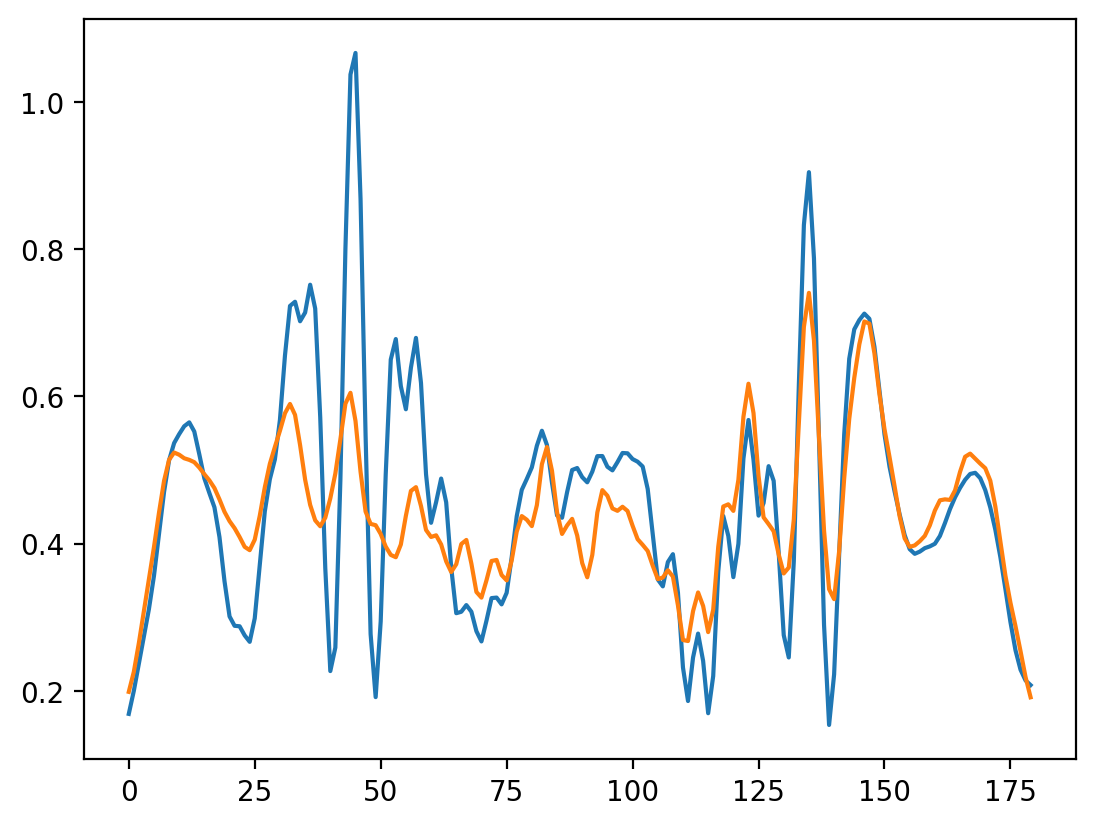

In [52]:
plt.plot(amplitude[45, :, 2])
plt.plot(amplitude[-45, :, 2])